In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import shutil
import seaborn as sn
from os import listdir, walk, getcwd, mkdir
from os.path import isfile, join, sep
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.feature import hog
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# import resizing snippets
from conversion import *

In [2]:
# Create a fresh SVM subdirectory structure below
# If SVM or any of SVM subdirectory exists, then it removes the SVM subdirectory and create a new SVM folder with the structure below
# 
# +---.ipynb_checkpoints
# +---data
# |   \---Coronahack-Chest-XRay-Dataset
# |       \---Coronahack-Chest-XRay-Dataset
# |           +---SVM
# |           |   +---test_modified
# |           |   +---test_unique
# |           |   +---train_modified
# |           |   \---train_unique
# |           +---test
# |           \---train
# \---__pycache__


dir_path = "data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths = ["test_modified","train_modified","test_unique","train_unique"]

i = 0
loop_count = 0
while i < 4:
    loop_count += 1
    if loop_count == 7:
        break
    try:
        path = dir_path + '/SVM/' + subpaths[i]
        os.mkdir(path)
    except FileExistsError:
        # if folder exist then try remove the whole SVM subdirectory
        print("Directory " , 'SVM/' + subpaths[i] ,  " already exists")
        try:
            shutil.rmtree(dir_path + '/SVM/')
        except OSError as e:
            print("Error: %s : %s" % (dir_path, e.strerror))
    except OSError:
        print ("Creation of the directory %s failed" % subpaths[i])
        path = dir_path + '/SVM/'
        os.mkdir(path)
    else:
        print ("Successfully created the directory %s " % subpaths[i])
        i += 1

Directory  SVM/test_modified  already exists
Creation of the directory test_modified failed
Successfully created the directory test_modified 
Successfully created the directory train_modified 
Successfully created the directory test_unique 
Successfully created the directory train_unique 


In [3]:
# Show metadata of dataset

filename = "data/Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
# create dict mapping image names to labels

label_dict = dict()
lim = 10
i = 0
for i, row in meta_df.iterrows():
    label_dict[row.X_ray_image_name] = [row.Label, row.Label_2_Virus_category, row.Label_1_Virus_category]
CLASS_NAMES = meta_df.Label.unique()

In [5]:
def collect_files(path, subpaths, label = False):
    """Collate paths of files (images)
    
    Args:
        path (type = string): the folder path of the images
        subpath (type = list): subdirectories of paths
        labels (type = boolean): collate corresponding labels for images. Default to False

    Returns:
        tuple (f,l) where:
            f (type = list): List of filepaths
            l (type = list): List of corresponding labels to f
    """
    f=[]
    l=[]
    i=0
    for subpath in subpaths:
        for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
            for file in filenames:
                f.append("{}/{}/{}".format(path,subpath,file))
                if label == True:
                    l.append(label_dict[file][0])
            break
    return f,l

In [6]:
def shape_rgb_or_grey(img):
    """number of rows, columns and transform image channels to string
    
    Args:
        img (image): image
    Returns:
        list (shp[0], shp[1], color) where:
        shp[0] (type = int): number of rows
        shp[1] (type = int): number of columns 
        color (type = string): img channel type (RGB or GREY)
    """
    
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

def summarize_images(f,meta_df):
    '''Statistical summary of element of a list of filepath (f)
    
    Args:
        f (type = list): list of image filepaths
    Returns:
        list (df_sizes, bad_images) where:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
        bad_images (type = list): images not found in meta_df (Chest_xray_Corona_Metadata)  
    '''
    datasplit_list=[]
    row_nums=[]
    col_nums=[]
    aspect_ratios=[]
    name_short=[]
    labels_list=[]
    file_type=[]
    color_list=[]
    bad_images=[]
    print("--- Parsing {} images ---".format(len(f)))
    print_every = 500
    i = 0

    for filename in f:
        file_short = filename.split("/")[-1]
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
            img = imread(filename)
            try:
                data_split = meta_df[meta_df.X_ray_image_name == file_short].Dataset_type.values[0]
                data_label = meta_df[meta_df.X_ray_image_name == file_short].Label.values[0]
                datasplit_list.append(data_split)
                rows, cols, color = shape_rgb_or_grey(img)
                row_nums.append(rows)
                col_nums.append(cols)
                aspect_ratios.append(cols/rows)
                name_short.append(filename.split("/")[-1])
                labels_list.append(data_label)
                file_type.append(file_ext)
                color_list.append(color)
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except IndexError:
                bad_images.append(file_short)
                print(f'--> {file_short} is not in metadata. Skipping.')
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print(file_short)
                raise

        else:
            print("Skipping {}.".format(filename))

    # summarize image sizes
    data = {"name": name_short, "dataset_type": datasplit_list, "ext": file_type, "color": color_list, "label": labels_list, "n_rows": row_nums, "n_cols": col_nums, "asp_ratio": aspect_ratios}
    df_sizes = pd.DataFrame(data=data,columns=["name", "dataset_type", "ext", "color", "label", "n_rows", "n_cols", "asp_ratio"])
    print(f"--- There were {len(bad_images)} images not included in the metadata .csv ---")
    return [df_sizes, bad_images]


# visualize distribution of image sizes
def df_size_plots(df_sizes):
    
    '''Plots heat map of file height and with and a histogram of image channels
    
    Args:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
    '''
    
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    # img size distribution
    hist2d = axs[0].hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
    plt.colorbar(hist2d[3],ax=axs[0])
    axs[0].set_title("Image Size Distribution")
    axs[0].set_xlabel("# Rows")
    axs[0].set_ylabel("# Cols")
    # rgb/color distribution
    colors = ["RGB","GREY"]
    vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
    axs[1].bar(colors,vals)
    axs[1].set_title("Image Color Distribution")
    axs[1].set_ylabel("Count")
    plt.show()

--- Parsing 5933 images ---
-> 0 images parsed
-> 500 images parsed
--> 1-s2.0-S0929664620300449-gr3_lrg-a.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-b.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-c.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-d.jpg is not in metadata. Skipping.
--> 191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg is not in metadata. Skipping.
--> 21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg is not in metadata. Skipping.
--> 396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg is not in metadata. Skipping.
--> 3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg is not in metadata. Skipping.
--> 5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg is not in metadata. Skipping.
--> 66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg is not in metadata. Skipping.
--> 6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg is not in metadata. Skipping.
--> 925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg is not in metadata. Skipping.
--> DE488FE1-0C44-428B-B67A-0974

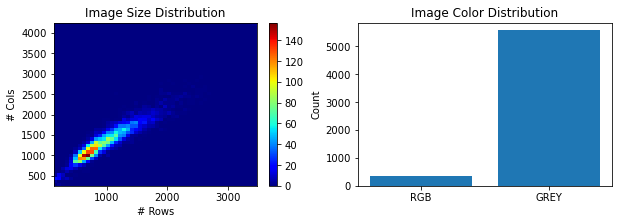

In [7]:
# Plotting the distribution of image sizes and channels in the train and test directory

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test","train"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)
row_mean = df_sizes.n_rows.mean()
col_mean = df_sizes.n_cols.mean()

In [8]:
# Run conversion script on images in the train and test subdirectories.
# Save converted images to test_modified and train_modified subdirectories.
# The conversion script rescales the largest dimension (width or length) of the image to 295 while preservating aspect ratio.
# Add Gaussian noise from mean = 50, std dev = 1 to image.
# Zero pad image so resulting dimension is 300 x 300.
# Only images with metadata are converted and saved

RESIZE_BOOL = False # Originally True
ROWS = int(row_mean/2) # Does nothing since RESIZE_BOOL is False
COLS = int(col_mean/2) # Does nothing since RESIZE_BOOL is False
           
path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["test","train"]
dest_subpaths = ["SVM/test_modified","SVM/train_modified"]

for i in range(len(source_subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    # Same as simulation #1 except it's True, 300, True, 295. 9th input variable set to True. 10th variable set to 50. 11th variable set to 1.
    convert_image(test_path,test_destination_path,COLS,ROWS,RESIZE_BOOL,False,False,10,True,50,1,False,0.2,False,0.2,True,300,True,295,label_dict,print_every=200)

200 files processed out of 624 files.
400 files processed out of 624 files.
600 files processed out of 624 files.
--- There were 0 images without labels ---
200 files processed out of 5309 files.
400 files processed out of 5309 files.
600 files processed out of 5309 files.
800 files processed out of 5309 files.
1000 files processed out of 5309 files.
1200 files processed out of 5309 files.
1400 files processed out of 5309 files.
1600 files processed out of 5309 files.
1800 files processed out of 5309 files.
2000 files processed out of 5309 files.
2200 files processed out of 5309 files.
2400 files processed out of 5309 files.
2600 files processed out of 5309 files.
2800 files processed out of 5309 files.
3000 files processed out of 5309 files.
3200 files processed out of 5309 files.
3400 files processed out of 5309 files.
3600 files processed out of 5309 files.
3800 files processed out of 5309 files.
4000 files processed out of 5309 files.
4200 files processed out of 5309 files.
4400 fi

--- Parsing 5910 images ---
-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed
-> 5500 images parsed
--- There were 0 images not included in the metadata .csv ---


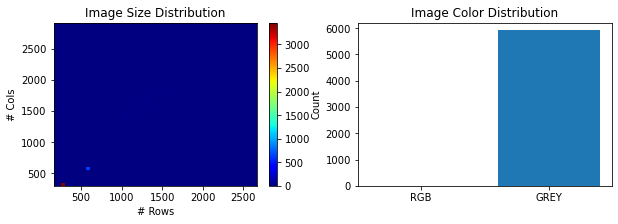

In [9]:
# Plotting the distribution of image sizes and channels for converted images.

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["SVM/test_modified","SVM/train_modified"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)

In [10]:
# Pick one converted image per subject.
# Save the picked images in test_unique and train_unique subdirectories

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["SVM/test_modified","SVM/train_modified"]
dest_subpaths = ["SVM/test_unique","SVM/train_unique"]

for i in range(len(subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    list_unique_x_ray(test_path,test_destination_path,False,True,True)

1 files processed out of 415 files.
2 files processed out of 415 files.
3 files processed out of 415 files.
4 files processed out of 415 files.
5 files processed out of 415 files.
6 files processed out of 415 files.
7 files processed out of 415 files.
8 files processed out of 415 files.
9 files processed out of 415 files.
10 files processed out of 415 files.
11 files processed out of 415 files.
12 files processed out of 415 files.
13 files processed out of 415 files.
14 files processed out of 415 files.
15 files processed out of 415 files.
16 files processed out of 415 files.
17 files processed out of 415 files.
18 files processed out of 415 files.
19 files processed out of 415 files.
20 files processed out of 415 files.
21 files processed out of 415 files.
22 files processed out of 415 files.
23 files processed out of 415 files.
24 files processed out of 415 files.
25 files processed out of 415 files.
26 files processed out of 415 files.
27 files processed out of 415 files.
28 files p

19 files processed out of 2700 files.
20 files processed out of 2700 files.
21 files processed out of 2700 files.
22 files processed out of 2700 files.
23 files processed out of 2700 files.
24 files processed out of 2700 files.
25 files processed out of 2700 files.
26 files processed out of 2700 files.
27 files processed out of 2700 files.
28 files processed out of 2700 files.
29 files processed out of 2700 files.
30 files processed out of 2700 files.
31 files processed out of 2700 files.
32 files processed out of 2700 files.
33 files processed out of 2700 files.
34 files processed out of 2700 files.
35 files processed out of 2700 files.
36 files processed out of 2700 files.
37 files processed out of 2700 files.
38 files processed out of 2700 files.
39 files processed out of 2700 files.
40 files processed out of 2700 files.
41 files processed out of 2700 files.
42 files processed out of 2700 files.
43 files processed out of 2700 files.
44 files processed out of 2700 files.
45 files pro

236 files processed out of 2700 files.
237 files processed out of 2700 files.
238 files processed out of 2700 files.
239 files processed out of 2700 files.
240 files processed out of 2700 files.
241 files processed out of 2700 files.
242 files processed out of 2700 files.
243 files processed out of 2700 files.
244 files processed out of 2700 files.
245 files processed out of 2700 files.
246 files processed out of 2700 files.
247 files processed out of 2700 files.
248 files processed out of 2700 files.
249 files processed out of 2700 files.
250 files processed out of 2700 files.
251 files processed out of 2700 files.
252 files processed out of 2700 files.
253 files processed out of 2700 files.
254 files processed out of 2700 files.
255 files processed out of 2700 files.
256 files processed out of 2700 files.
257 files processed out of 2700 files.
258 files processed out of 2700 files.
259 files processed out of 2700 files.
260 files processed out of 2700 files.
261 files processed out o

449 files processed out of 2700 files.
450 files processed out of 2700 files.
451 files processed out of 2700 files.
452 files processed out of 2700 files.
453 files processed out of 2700 files.
454 files processed out of 2700 files.
455 files processed out of 2700 files.
456 files processed out of 2700 files.
457 files processed out of 2700 files.
458 files processed out of 2700 files.
459 files processed out of 2700 files.
460 files processed out of 2700 files.
461 files processed out of 2700 files.
462 files processed out of 2700 files.
463 files processed out of 2700 files.
464 files processed out of 2700 files.
465 files processed out of 2700 files.
466 files processed out of 2700 files.
467 files processed out of 2700 files.
468 files processed out of 2700 files.
469 files processed out of 2700 files.
470 files processed out of 2700 files.
471 files processed out of 2700 files.
472 files processed out of 2700 files.
473 files processed out of 2700 files.
474 files processed out o

665 files processed out of 2700 files.
666 files processed out of 2700 files.
667 files processed out of 2700 files.
668 files processed out of 2700 files.
669 files processed out of 2700 files.
670 files processed out of 2700 files.
671 files processed out of 2700 files.
672 files processed out of 2700 files.
673 files processed out of 2700 files.
674 files processed out of 2700 files.
675 files processed out of 2700 files.
676 files processed out of 2700 files.
677 files processed out of 2700 files.
678 files processed out of 2700 files.
679 files processed out of 2700 files.
680 files processed out of 2700 files.
681 files processed out of 2700 files.
682 files processed out of 2700 files.
683 files processed out of 2700 files.
684 files processed out of 2700 files.
685 files processed out of 2700 files.
686 files processed out of 2700 files.
687 files processed out of 2700 files.
688 files processed out of 2700 files.
689 files processed out of 2700 files.
690 files processed out o

876 files processed out of 2700 files.
877 files processed out of 2700 files.
878 files processed out of 2700 files.
879 files processed out of 2700 files.
880 files processed out of 2700 files.
881 files processed out of 2700 files.
882 files processed out of 2700 files.
883 files processed out of 2700 files.
884 files processed out of 2700 files.
885 files processed out of 2700 files.
886 files processed out of 2700 files.
887 files processed out of 2700 files.
888 files processed out of 2700 files.
889 files processed out of 2700 files.
890 files processed out of 2700 files.
891 files processed out of 2700 files.
892 files processed out of 2700 files.
893 files processed out of 2700 files.
894 files processed out of 2700 files.
895 files processed out of 2700 files.
896 files processed out of 2700 files.
897 files processed out of 2700 files.
898 files processed out of 2700 files.
899 files processed out of 2700 files.
900 files processed out of 2700 files.
901 files processed out o

1102 files processed out of 2700 files.
1103 files processed out of 2700 files.
1104 files processed out of 2700 files.
1105 files processed out of 2700 files.
1106 files processed out of 2700 files.
1107 files processed out of 2700 files.
1108 files processed out of 2700 files.
1109 files processed out of 2700 files.
1110 files processed out of 2700 files.
1111 files processed out of 2700 files.
1112 files processed out of 2700 files.
1113 files processed out of 2700 files.
1114 files processed out of 2700 files.
1115 files processed out of 2700 files.
1116 files processed out of 2700 files.
1117 files processed out of 2700 files.
1118 files processed out of 2700 files.
1119 files processed out of 2700 files.
1120 files processed out of 2700 files.
1121 files processed out of 2700 files.
1122 files processed out of 2700 files.
1123 files processed out of 2700 files.
1124 files processed out of 2700 files.
1125 files processed out of 2700 files.
1126 files processed out of 2700 files.


1318 files processed out of 2700 files.
1319 files processed out of 2700 files.
1320 files processed out of 2700 files.
1321 files processed out of 2700 files.
1322 files processed out of 2700 files.
1323 files processed out of 2700 files.
1324 files processed out of 2700 files.
1325 files processed out of 2700 files.
1326 files processed out of 2700 files.
1327 files processed out of 2700 files.
1328 files processed out of 2700 files.
1329 files processed out of 2700 files.
1330 files processed out of 2700 files.
1331 files processed out of 2700 files.
1332 files processed out of 2700 files.
1333 files processed out of 2700 files.
1334 files processed out of 2700 files.
1335 files processed out of 2700 files.
1336 files processed out of 2700 files.
1337 files processed out of 2700 files.
1338 files processed out of 2700 files.
1339 files processed out of 2700 files.
1340 files processed out of 2700 files.
1341 files processed out of 2700 files.
1342 files processed out of 2700 files.


1534 files processed out of 2700 files.
1535 files processed out of 2700 files.
1536 files processed out of 2700 files.
1537 files processed out of 2700 files.
1538 files processed out of 2700 files.
1539 files processed out of 2700 files.
1540 files processed out of 2700 files.
1541 files processed out of 2700 files.
1542 files processed out of 2700 files.
1543 files processed out of 2700 files.
1544 files processed out of 2700 files.
1545 files processed out of 2700 files.
1546 files processed out of 2700 files.
1547 files processed out of 2700 files.
1548 files processed out of 2700 files.
1549 files processed out of 2700 files.
1550 files processed out of 2700 files.
1551 files processed out of 2700 files.
1552 files processed out of 2700 files.
1553 files processed out of 2700 files.
1554 files processed out of 2700 files.
1555 files processed out of 2700 files.
1556 files processed out of 2700 files.
1557 files processed out of 2700 files.
1558 files processed out of 2700 files.


1743 files processed out of 2700 files.
1744 files processed out of 2700 files.
1745 files processed out of 2700 files.
1746 files processed out of 2700 files.
1747 files processed out of 2700 files.
1748 files processed out of 2700 files.
1749 files processed out of 2700 files.
1750 files processed out of 2700 files.
1751 files processed out of 2700 files.
1752 files processed out of 2700 files.
1753 files processed out of 2700 files.
1754 files processed out of 2700 files.
1755 files processed out of 2700 files.
1756 files processed out of 2700 files.
1757 files processed out of 2700 files.
1758 files processed out of 2700 files.
1759 files processed out of 2700 files.
1760 files processed out of 2700 files.
1761 files processed out of 2700 files.
1762 files processed out of 2700 files.
1763 files processed out of 2700 files.
1764 files processed out of 2700 files.
1765 files processed out of 2700 files.
1766 files processed out of 2700 files.
1767 files processed out of 2700 files.


1970 files processed out of 2700 files.
1971 files processed out of 2700 files.
1972 files processed out of 2700 files.
1973 files processed out of 2700 files.
1974 files processed out of 2700 files.
1975 files processed out of 2700 files.
1976 files processed out of 2700 files.
1977 files processed out of 2700 files.
1978 files processed out of 2700 files.
1979 files processed out of 2700 files.
1980 files processed out of 2700 files.
1981 files processed out of 2700 files.
1982 files processed out of 2700 files.
1983 files processed out of 2700 files.
1984 files processed out of 2700 files.
1985 files processed out of 2700 files.
1986 files processed out of 2700 files.
1987 files processed out of 2700 files.
1988 files processed out of 2700 files.
1989 files processed out of 2700 files.
1990 files processed out of 2700 files.
1991 files processed out of 2700 files.
1992 files processed out of 2700 files.
1993 files processed out of 2700 files.
1994 files processed out of 2700 files.


2392 files processed out of 2700 files.
2393 files processed out of 2700 files.
2394 files processed out of 2700 files.
2395 files processed out of 2700 files.
2396 files processed out of 2700 files.
2397 files processed out of 2700 files.
2398 files processed out of 2700 files.
2399 files processed out of 2700 files.
2400 files processed out of 2700 files.
2401 files processed out of 2700 files.
2402 files processed out of 2700 files.
2403 files processed out of 2700 files.
2404 files processed out of 2700 files.
2405 files processed out of 2700 files.
2406 files processed out of 2700 files.
2407 files processed out of 2700 files.
2408 files processed out of 2700 files.
2409 files processed out of 2700 files.
2410 files processed out of 2700 files.
2411 files processed out of 2700 files.
2412 files processed out of 2700 files.
2413 files processed out of 2700 files.
2414 files processed out of 2700 files.
2415 files processed out of 2700 files.
2416 files processed out of 2700 files.


2601 files processed out of 2700 files.
2602 files processed out of 2700 files.
2603 files processed out of 2700 files.
2604 files processed out of 2700 files.
2605 files processed out of 2700 files.
2606 files processed out of 2700 files.
2607 files processed out of 2700 files.
2608 files processed out of 2700 files.
2609 files processed out of 2700 files.
2610 files processed out of 2700 files.
2611 files processed out of 2700 files.
2612 files processed out of 2700 files.
2613 files processed out of 2700 files.
2614 files processed out of 2700 files.
2615 files processed out of 2700 files.
2616 files processed out of 2700 files.
2617 files processed out of 2700 files.
2618 files processed out of 2700 files.
2619 files processed out of 2700 files.
2620 files processed out of 2700 files.
2621 files processed out of 2700 files.
2622 files processed out of 2700 files.
2623 files processed out of 2700 files.
2624 files processed out of 2700 files.
2625 files processed out of 2700 files.


In [12]:
def hog_descriptor(f_paths,image = False): 
    
    '''Computes Histogram of Oriented Gradients 
    
    Args:
        f_path (type = list): list of image filepaths
        image (type = bool/list): True to capture hod image array for ALL images, list to capature only the indexes in the list
    Returns:
        tuple (hog_fd, img_dict) where:
        hog_fd (type = list): hog feature description 
        img_dict (type = list): hog image  
    '''
    
    hog_fd = []
    img_dict = {}
    i = 0
    print_every = 500
        
    for filename in f_paths:
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
    
            img = imread(filename)
            try:
                if ((image == True) or (i in image)):
                    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt=True, block_norm="L1", visualize=True)
                    hog_fd.append(fd)
                    img_dict[i]= hog_image                
                else:
                    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt= True, block_norm="L1")
                    hog_fd.append(fd)

                
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except:
                print("Unknown exception occurred.") 
            
        else:
            print("Skipping {}.".format(filename))
            
    return(hog_fd, img_dict)

In [13]:
subpaths = ["SVM/train_unique"]

f_train,label_train = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in training set
hog_train, img_train = hog_descriptor(f_train,[1,2,3]) 

-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed


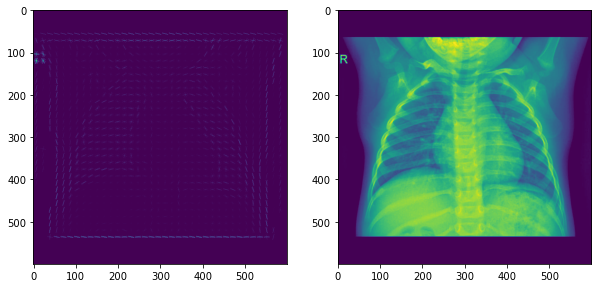

In [15]:
# Plot  hog image on the left and corresponding x-ray on the right

ex_img_train = imread(f_train[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_train[2]/img_train[2].max()) 
ax[1].imshow(ex_img_train)

In [16]:
subpaths = ["SVM/test_unique"]

f_test, label_test = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in test set
hog_test, img_test = hog_descriptor(f_test, [2,3])

-> 0 images parsed


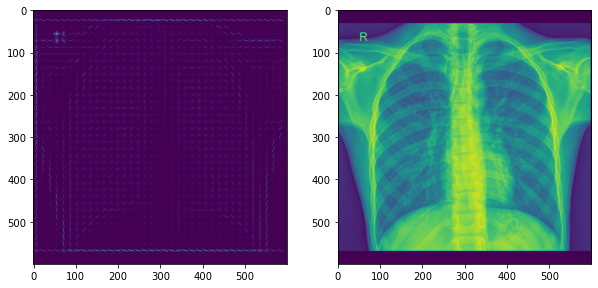

In [18]:
# Plot  hog image on the left and corresponding x-ray on the right

ex_img_test = imread(f_test[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_test[2]/img_test[2].max()) 
ax[1].imshow(ex_img_test)

In [19]:
def data_stack(hog_fd,label):
    ''' Creates  array of hog descriptors and a flattened array of their corresponding labels

    Args:
        hog_fd (type = list): list of hog feature description 
        label (list): list of labels of hog_fd
    Returns:
        tuple (X, y) where:
        X (type = array): stacked hog feature description in hog_fd  
        y (type = array): flattened array of labels of hog_fd 
    '''
    label =  np.array(label).reshape(len(label),1)
    hog_fd = np.array(hog_fd)

    x,y = hog_fd,label.ravel()
    return (x,y)

In [20]:
# Preprocessed training and test set

x_train,y_train = data_stack(hog_train,label_train)
x_test,y_test = data_stack(hog_test,label_test)

In [22]:
# Standardize data
# fit support vector classifier with the polynomial kernel and hyper-parameters C=1, and gamma=0.1.

model = make_pipeline(StandardScaler(), SVC(C=1, gamma=0.1, kernel='poly',probability = True,random_state = 7))
model.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma=0.1, kernel='poly', probability=True,
                     random_state=7))])

In [23]:
# Perform prediction using the preprocessed test set

predictions_probs = model.predict_proba(x_test)
predictions = model.predict(x_test)

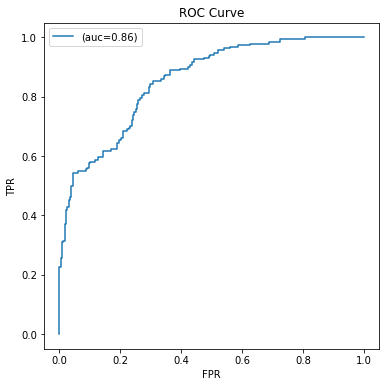

In [24]:
# Plot ROC curve

fpr, tpr,_ = metrics.roc_curve(y_test,predictions_probs[:,1] ,pos_label='Pnemonia')
auc = metrics.roc_auc_score(y_test,predictions_probs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label='(auc={:3.2f})'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.legend()

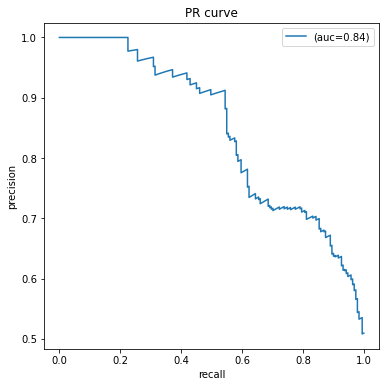

In [25]:
# Plot PR curve

prec, rec, threshs = metrics.precision_recall_curve(y_test,predictions_probs[:,1],pos_label='Pnemonia')
auc = metrics.auc(rec, prec)
plt.figure(figsize=(6,6))
plt.plot(rec,prec,label='(auc={:3.2f})'.format(auc))
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("PR curve")
plt.legend()

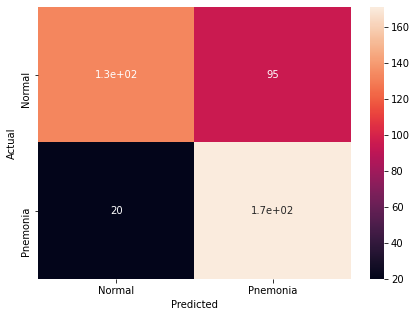

In [26]:
# Plot confusion matrix

data = {"y_test": y_test, "y_hat":predictions}
df = pd.DataFrame(data, columns=["y_test", "y_hat"])
confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
f, ax = plt.subplots(figsize=(7,5))
sn.heatmap(confusion_matrix, annot=True)
plt.show()